<a href="https://colab.research.google.com/github/BSteiner1/Adversarial-Examples/blob/main/Notebooks/Differential_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [358]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from matplotlib.patches import Circle

In [129]:
# Load Fashion MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [130]:
labels_dict = {0 : "T-shirt/top",
               1 : "Trouser",
               2 : "Pullover",
               3 : "Dress",
               4 : "Coat",
               5 : "Sandal",
               6 : "Shirt",
               7 : "Sneaker",
               8 : "Bag",
               9 : "Ankle boot"}

In [388]:
def prediction_and_confidence(image, model):

    output = model(image.unsqueeze(0))
    prediction = torch.argmax(output).item()

    # Get the confidence associated with the original prediction
    image_probabilities = F.softmax(output, dim=1)
    confidence = image_probabilities[0, prediction].item()

    return prediction, confidence

In [79]:
def image_confidence(image, model, label):

    model.eval()

    with torch.no_grad():
        output = model(image.unsqueeze(0))

    # Get the confidence associated with the original prediction
    image_probabilities = F.softmax(output, dim=1)
    confidence = image_probabilities[0][label].item()

    #print(label)
    #print(image_probabilities)

    return confidence

In [300]:
def apply_mutation(image, mutation):

    x, y, p = mutation

    image[0][int(x)][int(y)] = p

    return image

In [11]:
# Define the CNN model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(3136, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MA498/CNN_model.pth'))
model.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [708]:
def differential_evolution(tensor, model):

  model.eval()
  image, label = tensor

  population = [np.array([random.randint(0,27), random.randint(0,27), random.uniform(-1,1)]) for _ in range(1000)]

  for iter in range(10):
      if iter % 5 == 0:
        print(iter)
      for j in range(1000):

          parent_mutation = population[j]
          candidates = [i for i in range(1000) if i != j]
          a, b, c = np.random.choice(candidates, 3, replace=False)

          # Create mutant vector and clip if necessary
          child_mutation = population[a] + 0.2 * (population[b] - population[c])
          child_mutation[:2] = np.round(child_mutation[:2]).astype(int)
          child_mutation = np.clip(child_mutation, [0, 0, -1.], [27, 27, 1.])

          parent = image.clone()
          child = image.detach().clone()

          parent = apply_mutation(parent, parent_mutation)
          child = apply_mutation(child, child_mutation)

          def fitness(parent, child, label):
              parent_confidence =  image_confidence(parent, model, label)
              child_confidence =  image_confidence(child, model, label)

              if child_confidence < parent_confidence:
                swap = True
                # if random.uniform(0,1) < 0.02:
                #   print(child_confidence)
                return child, swap
              else:
                swap = False
                return parent, swap

          fittest, swap = fitness(parent, child, label)
          if swap == True:
            population[j] = child_mutation
          else:
            None

  return population

In [709]:
num = 500
img = test_dataset[num]

In [710]:
solution = differential_evolution(img, model)

0
5


In [712]:
def best_mutation(tensor, model, population):

  model.eval()

  image, label = tensor
  image = image.numpy()

  mutation = []
  confidence = 1.
  min_idx = 0

  for idx, mut in enumerate(population):
    x = apply_mutation(image, mut)
    x = torch.tensor(x)
    conf = image_confidence(x, model, label)
    if conf < confidence:
      confidence = conf
      mutation = mut
      min_idx = idx

  return mutation

In [713]:
best = best_mutation(img, model, solution)
best

0.9783871173858643
0.9765783548355103
0.9622029066085815
0.9379023313522339
0.9179463982582092
0.8967089056968689
0.8731885552406311
0.8327346444129944
0.8116668462753296
0.7992762923240662
0.7989267706871033
0.753308117389679
0.7001649737358093
0.605876088142395
0.5727195739746094
0.5557454228401184
0.5216553211212158
0.4327668249607086
0.3928174376487732
0.3902682960033417
0.362849622964859
0.33582085371017456
0.3047904670238495
0.3028565049171448
0.23958976566791534
0.21367177367210388
0.2006864994764328
0.18370327353477478
0.16271764039993286
0.14574779570102692
0.10870053619146347
0.10188069194555283
0.09122731536626816
0.050451867282390594
0.04899926483631134
0.03977945074439049
0.035264983773231506
0.03466720134019852
0.027842063456773758
0.024445880204439163
0.024426789954304695
0.02420492097735405
0.023723114281892776
0.02224365808069706
0.02161356434226036
0.021586937829852104
0.02113720029592514
0.019109295681118965
0.01715659350156784
0.014490197412669659
0.0142801627516746

array([25., 17.,  1.])

In [714]:
img = test_dataset[num]

In [715]:
labels_dict[img[1]]

'Pullover'

In [716]:
image_confidence(img[0], model, img[1])

0.9840177893638611

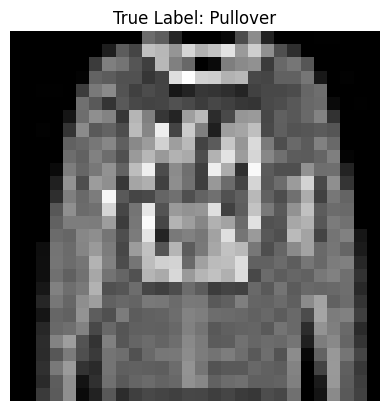

In [717]:
# Plot the array using matplotlib
plt.imshow(img[0][0], cmap='gray')  # Assuming grayscale values

plt.axis('off')  # Turn off axis
plt.title("True Label: " + labels_dict[img[1]])
plt.show()

In [718]:
adv_ex = apply_mutation(img[0], best)

In [719]:
pred, conf = prediction_and_confidence(adv_ex, model)

In [720]:
label_conf = image_confidence(adv_ex, model, img[1])

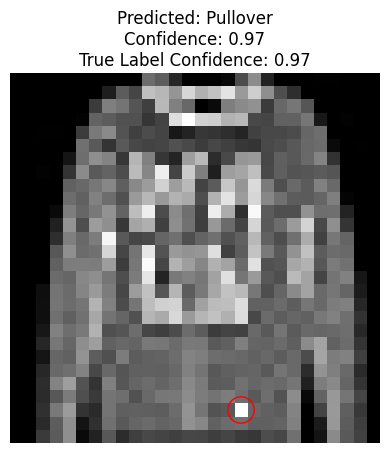

In [721]:
# Plot the array using matplotlib
plt.imshow(adv_ex[0], cmap='gray')  # Assuming grayscale values
plt.title("Predicted: " + labels_dict[pred] + '\nConfidence: ' + str(np.round(conf,2)) + "\nTrue Label Confidence: " + str(np.round(label_conf, 2)))
# Pixel coordinates (x, y) and radius of the circle
y, x = best[:2]
radius = 1

# Create a Circle patch
circle = Circle((x, y), radius, color='red', fill=False)

# Add the Circle patch to the plot
plt.gca().add_patch(circle)
plt.axis('off')  # Turn off axis
plt.show()